In [1]:
import numpy

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, phi, phiold, rho, const, dt):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._phiold = phiold
        self._rho = rho
        self._const = const
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._const*self._grid.vol*(self._phi[1:-1]-self._phiold[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._const*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs

In [2]:
class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, const, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._const = const
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._const*mdote[:-1]*self._phie[:-1]
        flux_e = self._const*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._const*mdote[1:]*self._phi[1:-1] + self._const*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._const*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._const*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [3]:
class AdvectingVelocityModel:
    """Class defining an advecting velocity model"""

    def __init__(self, grid, dhat, Uhe, P, U, coeffs):
        """Constructor"""
        self._grid = grid
        self._dhat = dhat
        self._Uhe = Uhe
        self._P = P
        self._U = U
        self._coeffs = coeffs

    def update(self):
        """Function to update the advecting velocity array"""

        # Calculate the pressure gradients across the faces
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        
        # Calculate the cell pressure gradients
        gradP = 0.5*(gradPw + gradPe)
          
        # Calculate damping coefficient, dhat
        Ve = 0.5*(self._grid.vol[0:-1] + self._grid.vol[1:])
        ae = 0.5*(self._coeffs.aP[0:-1] + self._coeffs.aP[1:])
        self._dhat[1:-1] = Ve/ae

        # Update the advecting velocity
        self._Uhe[0] = self._U[0]
        self._Uhe[1:-1] = 0.5*(self._U[1:-2] + self._U[2:-1]) + self._dhat[1:-1]*(gradPe[1:] - 0.5*(gradP[:-1] + gradP[1:]))
        self._Uhe[-1] = self._U[-1]

In [4]:
class PressureForceModel:
    """Class defining a pressure force model"""

    def __init__(self, grid, P, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._P = P
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the pressure force
        gradPw = (self._P[1:-1]-self._P[0:-2])/self._grid.dx_WP
        gradPe = (self._P[2:]-self._P[1:-1])/self._grid.dx_PE
        force = 0.5*(gradPw + gradPe)*self._grid.vol
          
        # Calculate the linearization coefficients
        coeffW = - 0.5*self._grid.vol/self._grid.dx_WP
        coeffE = 0.5*self._grid.vol/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(force)

        # Return the modified coefficient array
        return coeffs

In [5]:
class MassConservationEquation:
    """Class defining a mass conservation equation"""

    def __init__(self, grid, U, P, dhat, Uhe, rho, 
                 P_west_bc, P_east_bc, U_west_bc, U_east_bc):
        """Constructor"""
        self._grid = grid
        self._U = U
        self._P = P
        self._dhat = dhat
        self._Uhe = Uhe
        self._rho = rho
        self._P_west_bc = P_west_bc
        self._P_east_bc = P_east_bc
        self._U_west_bc = U_west_bc
        self._U_east_bc = U_east_bc

    def add(self, PP_coeffs, PU_coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the mass imbalance, based on advecting velocities
        imbalance = self._rho*self._grid.Ae*self._Uhe[1:] - self._rho*self._grid.Aw*self._Uhe[:-1]
              
        # Calculate the linearization coefficients on pressure
        PP_coeffW = np.concatenate((np.array([0]), -self._rho*self._grid.Aw[1:]*self._dhat[1:-1]/self._grid.dx_WP[1:]))
        PP_coeffE = np.concatenate((-self._rho*self._grid.Ae[:-1]*self._dhat[1:-1]/self._grid.dx_PE[:-1], np.array([0])))
        PP_coeffP = - PP_coeffW - PP_coeffE
        
        # Calculate the linearization coefficients on velocity
        PU_coeffW = np.concatenate((np.array([-self._rho*self._grid.Aw[0]]), -0.5*self._rho*self._grid.Aw[1:]))
        PU_coeffE = np.concatenate((0.5*self._rho*self._grid.Ae[:-1], np.array([self._rho*self._grid.Ae[-1]])))
        PU_coeffP = np.concatenate((np.array([0]), PU_coeffW[1:])) + np.concatenate((PU_coeffE[:-1], np.array([0])))

        # Modify the linearization coefficients on the boundaries 
        # (velocity only, since pressure is already zero)
        PU_coeffP[0] += PU_coeffW[0]*self._U_west_bc.coeff()
        PU_coeffP[-1] += PU_coeffE[-1]*self._U_east_bc.coeff()

        # Zero the boundary coefficients that are not used
        PU_coeffW[0] = 0.0
        PU_coeffE[-1] = 0.0

        # Add to coefficient arrays
        PP_coeffs.accumulate_aP(PP_coeffP)
        PP_coeffs.accumulate_aW(PP_coeffW)
        PP_coeffs.accumulate_aE(PP_coeffE)
        PP_coeffs.accumulate_rP(imbalance)
        PU_coeffs.accumulate_aP(PU_coeffP)
        PU_coeffs.accumulate_aW(PU_coeffW)
        PU_coeffs.accumulate_aE(PU_coeffE)

        # Return the modified coefficient arrays
        return PP_coeffs, PU_coeffs

In [6]:
#------------------------------------is the model correct?-------------------------------------------------------------------#

class ShearForceModel:
    """Class defining a shear force model"""

    def __init__(self, grid, ly, lz, U, rho, mu):
        """Constructor"""
        self._grid = grid
        self._ly = ly
        self._lz = lz
        self._U = U
        self._rho = rho
        self._mu = mu

    def add(self, coeffs):
        """Function to add force terms to coefficient arrays"""

        # Calculate the source term
        
        import numpy as np
       # self._grid.Af could not be used as number of element Af is 11 where Ao is 10 so mismatch!
        Dh = np.sqrt(self._ly * self._lz) # Is this way Ok?
        # As in this case the area is the area of a square so it turned out that Dh becomes the square root of the area.
       
        Re = (self._rho * self._U[1:-1] * Dh) / self._mu
        Cf = 1 / np.power(( 1.58 * np.log(Re) - 3.28 ), 2)
        source = Cf * 0.5 * self._rho * np.power(self._U[1:-1], 2) * self._grid.Ao
        

        # Calculate the linearization coefficients
        coeffP =Cf * self._rho * self._U[1:-1] * self._grid.Ao
        

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

In [7]:
#------------------------------------is the model correct?-------------------------------------------------------------------#
class ExtrapolatedBc:
    """Class defining an extrapolated boundary condition"""

    def __init__(self, phi, grid, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - (self._phi[2]-self._phi[1])/self._grid.dx_WP[1]*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + (self._phi[-2]-self._phi[-3])/self._grid.dx_PE[-2]*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return 1 + 1/self._grid.dx_WP[1]*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return 1 + 1/self._grid.dx_PE[-2]*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            pass # Is the following correct????????????????????????????????????????????
            self._phi[0] = self._phi[1] - (self._phi[2]-self._phi[1])/self._grid.dx_WP[1]*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            pass # Is the following correct????????????????????????????????????????????
            self._phi[-1] = self._phi[-2] + (self._phi[-2]-self._phi[-3])/self._grid.dx_PE[-2]*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [8]:
from Lesson5.Grid import Grid
from Lesson5.ScalarCoeffs import ScalarCoeffs
from Lesson5.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Lesson5.Models import DiffusionModel
from Lesson5.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 1e9
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
mu = 1e-3

# Define the coefficients
PU_coeffs = ScalarCoeffs(grid.ncv)
PP_coeffs = ScalarCoeffs(grid.ncv)
UP_coeffs = ScalarCoeffs(grid.ncv)
UU_coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
U0 = 10
P0 = 0

# Initialize field variable arrays
U = U0*np.ones(grid.ncv+2)
P = P0*np.ones(grid.ncv+2)

# Initialize advecting velocity and damping coefficient array
dhat = np.zeros(grid.ncv+1)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions for velocity
U_west_bc = DirichletBc(U, grid, U0, BoundaryLocation.WEST)
U_east_bc = NeumannBc(U, grid, 0, BoundaryLocation.EAST)

# Define boundary conditions for pressure
P_west_bc = ExtrapolatedBc(P, grid, BoundaryLocation.WEST)
P_east_bc = DirichletBc(P, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
U_west_bc.apply()
U_east_bc.apply()
P_west_bc.apply()
P_east_bc.apply()

# Define the transient model
Uold = np.copy(U)
transient = FirstOrderTransientModel(grid, U, Uold, rho, 1, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, U, mu, U_west_bc, U_east_bc)

# Define the advection model
advection = UpwindAdvectionModel(grid, U, Uhe, rho, 1, U_west_bc, U_east_bc)

# Define the pressure force model
pressure = PressureForceModel(grid, P, P_west_bc, P_east_bc)

#---------------------------------------------------------------------------------------------------------------------------#
# Define the shear force model
shear = ShearForceModel(grid, ly, lz, U, rho, mu) # Is this the right place to call it?????????????????????
#---------------------------------------------------------------------------------------------------------------------------#

# Define advecting velocity model
advecting = AdvectingVelocityModel(grid, dhat, Uhe, P, U, UU_coeffs)

# Define conservation of mass equation
mass = MassConservationEquation(grid, U, P, dhat, Uhe, rho, 
                                P_west_bc, P_east_bc, U_west_bc, U_east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt
    
    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))
    
    # Store the "old" velocity field
    Uold[:] = U[:]
    
    # Iterate until the solution is converged
    for i in range(maxIter):
        
        # Zero all of the equations
        PP_coeffs.zero()
        PU_coeffs.zero()
        UU_coeffs.zero()
        UP_coeffs.zero()     
        
        # Assemble the momentum equations
        #   Note: do this before mass, because the coeffs are needed to compute advecting velocity
        UU_coeffs = diffusion.add(UU_coeffs)
        UU_coeffs = advection.add(UU_coeffs)
        UU_coeffs = transient.add(UU_coeffs)
        UU_coeffs = shear.add(UU_coeffs) # Is this the right way & place to add coeffs????????????????????????????
        UP_coeffs = pressure.add(UP_coeffs)
        
        # Assemble the mass equations
        advecting.update()
        PP_coeffs, PU_coeffs = mass.add(PP_coeffs, PU_coeffs)

        # Compute residuals and check for convergence
        PmaxResid = norm(PU_coeffs.rP + PP_coeffs.rP, np.inf)
        PavgResid = np.mean(np.absolute(PU_coeffs.rP + PP_coeffs.rP))
        UmaxResid = norm(UU_coeffs.rP + UP_coeffs.rP, np.inf)
        UavgResid = np.mean(np.absolute(UU_coeffs.rP + UP_coeffs.rP))
        print("Iteration = {}.".format(i))
        print("  Mass:     Max. Resid. = {}; Avg. Resid. = {}".format(PmaxResid, PavgResid))
        print("  Momentum: Max. Resid. = {}; Avg. Resid. = {}".format(UmaxResid, UavgResid))
        if PmaxResid < converged and UmaxResid < converged:
            break
    
        # Solve the sparse matrix system
        dP, dU = solve(PP_coeffs, PU_coeffs, UP_coeffs, UU_coeffs)
    
        # Update the solutions 
        P[1:-1] += dP
        U[1:-1] += dU
        
        # Update boundary conditions
        U_west_bc.apply()
        U_east_bc.apply()
        P_west_bc.apply()
        P_east_bc.apply()
        
        # Update the advecting velocities
        advecting.update()


Timestep = 0; Time = 1000000000.0
Iteration = 0.
  Mass:     Max. Resid. = 0.0; Avg. Resid. = 0.0
  Momentum: Max. Resid. = 12.491262739400385; Avg. Resid. = 12.491262739400385
Iteration = 1.
  Mass:     Max. Resid. = 1.7696377988886556; Avg. Resid. = 0.8137048573176306
  Momentum: Max. Resid. = 18.48023038447558; Avg. Resid. = 4.6292832797589245
Iteration = 2.
  Mass:     Max. Resid. = 1.6917122215662372; Avg. Resid. = 0.8299720874946136
  Momentum: Max. Resid. = 4.498320546123709; Avg. Resid. = 1.1384812200765138
Iteration = 3.
  Mass:     Max. Resid. = 0.6431312763205388; Avg. Resid. = 0.2741409857708968
  Momentum: Max. Resid. = 0.595842370002714; Avg. Resid. = 0.2564164296437713
Iteration = 4.
  Mass:     Max. Resid. = 0.3457940419036878; Avg. Resid. = 0.20143666173105945
  Momentum: Max. Resid. = 0.2656953306752641; Avg. Resid. = 0.10482437811702106
Iteration = 5.
  Mass:     Max. Resid. = 0.26842096931738313; Avg. Resid. = 0.10992702646287125
  Momentum: Max. Resid. = 0.82860531

[156140.78647918 140526.71097164 109298.55995657  78070.38630542
  46842.22997736  15614.08297458      0.        ]


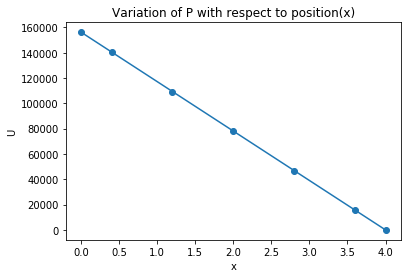

In [9]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# Define the grid
# Define the grid
lx = 4.0
ly = 0.02
lz = 0.02
ncv = 5
grid = Grid(lx, ly, lz, ncv)

x = np.linspace(0,4,ncv+2)
print(P)
plt.plot(grid.xP, P, marker='o')
plt.title('Variation of P with respect to position(x)')
plt.xlabel("x")
plt.ylabel("U")
plt.show()

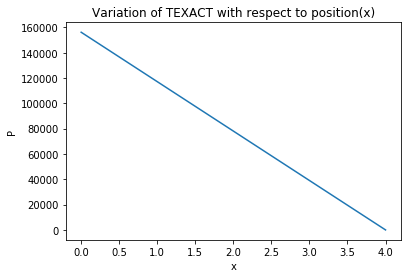

In [10]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# List of values of the parameters 
L=lx= 4.0 
ly  = 0.02
lz  = 0.02
rho = 1000
U   = 10
mu  = 1e-3
ncv = 10
x   = np.linspace(0,4,ncv)
Po  = 2*(ly + lz)
A   = ly * lz
Dh  = (4*A)/Po
Re  = rho*Dh*U/mu
Cf  = 1 / np.power(( 1.58 * np.log(Re) - 3.28 ), 2)
P   = (0.5 * rho * Cf * U**2 * Po * (L - x))/A

plt.plot(x, P)
plt.title('Variation of TEXACT with respect to position(x)')
plt.xlabel("x")
plt.ylabel("P")
plt.show()